In [1]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
from itertools import product

# Fix HTTPS certificate error
import ssl
ssl_create_default_https_context = ssl._create_unverified_context
from CustomImageDataset import CustomImageDataset


# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
set_seed(42)  

In [3]:
base_path = "/Users/orcunkarabicak/Documents/JADS/Deep Learning/Project/input/IDC_regular_ps50_idx5/"

In [4]:
folders = [folder for folder in os.listdir(base_path) if not folder.startswith(".")]
print(len(folders))
# 279 patients. MacOS creates a hidden folder .DS_Store breaks the flow.

279


In [5]:
total_images = 0
for n in range(len(folders)):
    patient_id = folders[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)


data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folders)):
    patient_id = folders[n]
    patient_path = base_path + patient_id 
    for c in [0, 1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.loc[k, "path"] = class_path + image_path
            data.loc[k, "target"] = int(c)
            data.loc[k, "patient_id"] = patient_id
            k += 1  




In [6]:
# Custom dataset class

class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (Pandas DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 1]  # Access image path
        image = Image.open(img_path).convert('RGB')  # Load image and ensure RGB
        label = self.dataframe.iloc[idx, 2]  # Access the label

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
def calculate_mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    total_images = 0

    for images, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total_images
        total_images += images.size(0)
        # Compute mean and variance here
        mean += images.mean(2).sum(0) 
        variance += images.var(2).sum(0)

    # Final mean and variance
    mean /= total_images
    variance /= total_images


    return mean, variance

Our dataset is imbalanced. We will first split our dataset into train and test preserving the class ratios. Then, we will use StratifiedKFold in our train dataset.

In [8]:

# Transform and resize the data
base_transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Resize to 50x50
    transforms.ToTensor()  # Convert to tensor
])

In [9]:
# Hyperparameters
batch_size = 16
subset_ratio = 0.03  # Reduced dataset size for quicker training

epochs = 20
learning_rate = 0.001

In [10]:
# Data Pre-Processing
# Assuming "target" is the column containing class labels
le = LabelEncoder()
data["target"] = le.fit_transform(data["target"])
# Create custom datasets for training, validation and testing
full_train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data["target"])
test_dataset = BreastCancerDataset(test_df, transform=base_transform) # Test dataset is being held out to check generalizability of the final model 

print(f'Train dataset size: {full_train_df.shape}\n Test dataset size: {test_df.shape}')

Train dataset size: (222019, 3)
 Test dataset size: (55505, 3)


In [11]:
# Perform train-test split to select a subset while preserving class distribution
limited_train_df, _ = train_test_split(full_train_df, train_size=subset_ratio, random_state=42, stratify=full_train_df["target"])

# Check the size of the generated subset
print("Size of Subset:", len(limited_train_df))


Size of Subset: 6660


In [12]:
# Create a custom DataLoader for the training fold
train_dataset = BreastCancerDataset(limited_train_df, transform=base_transform)  # Base transform
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)

# Calculate fold-specific mean and standard deviation
mean, variance = calculate_mean_and_variance(train_loader)
std = np.sqrt(variance)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")


Mean: tensor([0.8128, 0.6357, 0.7344])
Standard Deviation: tensor([0.1022, 0.1559, 0.1168])


Label: 0


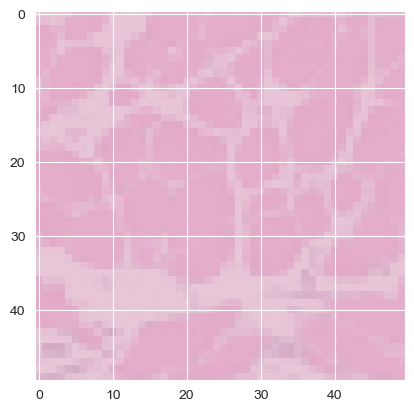

Label: 0


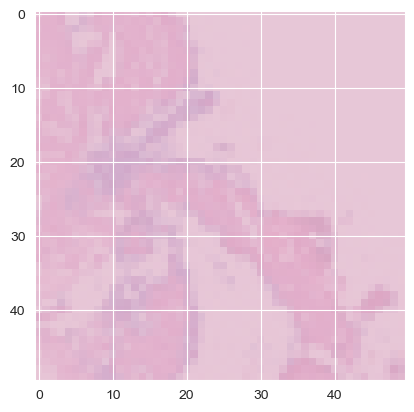

Label: 1


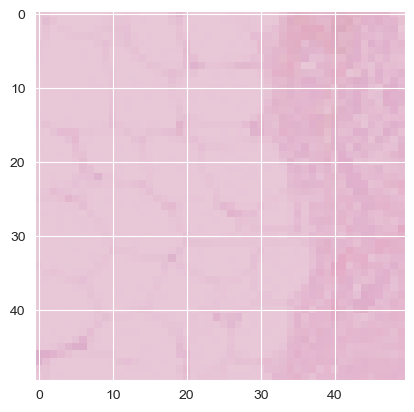

Label: 0


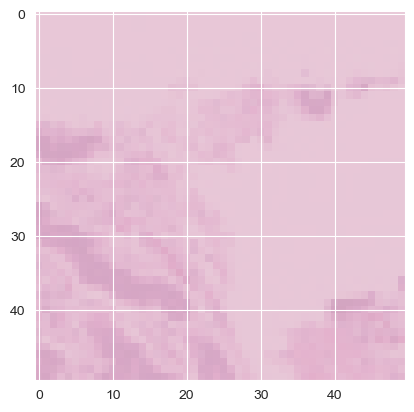

Label: 0


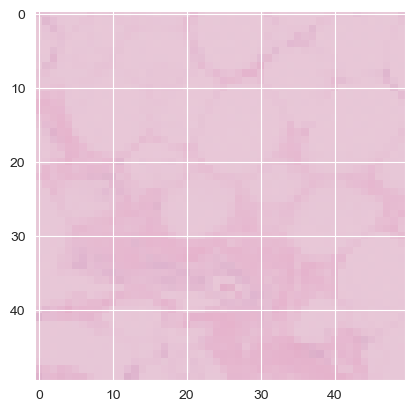

In [13]:
def denormalize(img, mean, std):
    """Denormalizes an image tensor using mean and std."""
    mean = torch.tensor(mean).reshape(-1, 1, 1) if not isinstance(mean, torch.Tensor) else mean.reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1) if not isinstance(std, torch.Tensor) else std.reshape(-1, 1, 1)
    img = img * std + mean  # Denormalize
    return img

def imshow(img, mean, std):
    """Displays a tensor as an image after denormalizing."""
    img = denormalize(img, mean, std)  # Denormalize
    img = torch.clamp(img, 0, 1)  # Clamp to [0, 1] range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from tensor image
    plt.show()

# Example: Display images
num_images = 5
classes = ['0', '1']  # Adjust as per your classes

for i in range(num_images):
    image, label = test_dataset[i]  # Direct unpacking
    print('Label:', classes[label])
    imshow(image, mean, std)

# Train and validate function

In [14]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                validation_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        validation_loss /= len(val_loader.dataset)
        validation_accuracy = 100 * correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    
    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")
    
    return train_losses, train_accuracies, validation_losses, validation_accuracies

def plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# CNN

In [15]:
class CNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 50x50x3 -> 25x25x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2: 25x25x32 -> 12x12x64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(12*12*64, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layer(x)
        return x

cnn_model = CNN().to(device)
print(cnn_model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=2,

In [ ]:
# model = CNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
# criterion = nn.CrossEntropyLoss() # Check this part nn.BCEWithLogitsLoss()
# 
# train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
# plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)

In [ ]:
# Training and cross validation

Epoch [1/20], Training Loss: 0.4203, Training Accuracy: 82.47%, Validation Loss: 0.8327, Validation Accuracy: 71.55%
Epoch [2/20], Training Loss: 0.3823, Training Accuracy: 84.14%, Validation Loss: 0.9322, Validation Accuracy: 71.62%
Epoch [3/20], Training Loss: 0.3656, Training Accuracy: 84.01%, Validation Loss: 0.6253, Validation Accuracy: 71.62%
Epoch [4/20], Training Loss: 0.3504, Training Accuracy: 85.29%, Validation Loss: 1.0562, Validation Accuracy: 71.62%
Epoch [5/20], Training Loss: 0.3380, Training Accuracy: 85.34%, Validation Loss: 0.7116, Validation Accuracy: 71.62%
Epoch [6/20], Training Loss: 0.3338, Training Accuracy: 85.87%, Validation Loss: 1.2143, Validation Accuracy: 71.62%
Epoch [7/20], Training Loss: 0.3263, Training Accuracy: 86.17%, Validation Loss: 1.2476, Validation Accuracy: 71.62%
Epoch [8/20], Training Loss: 0.3082, Training Accuracy: 86.86%, Validation Loss: 0.8025, Validation Accuracy: 71.62%
Epoch [9/20], Training Loss: 0.3023, Training Accuracy: 86.82%, 

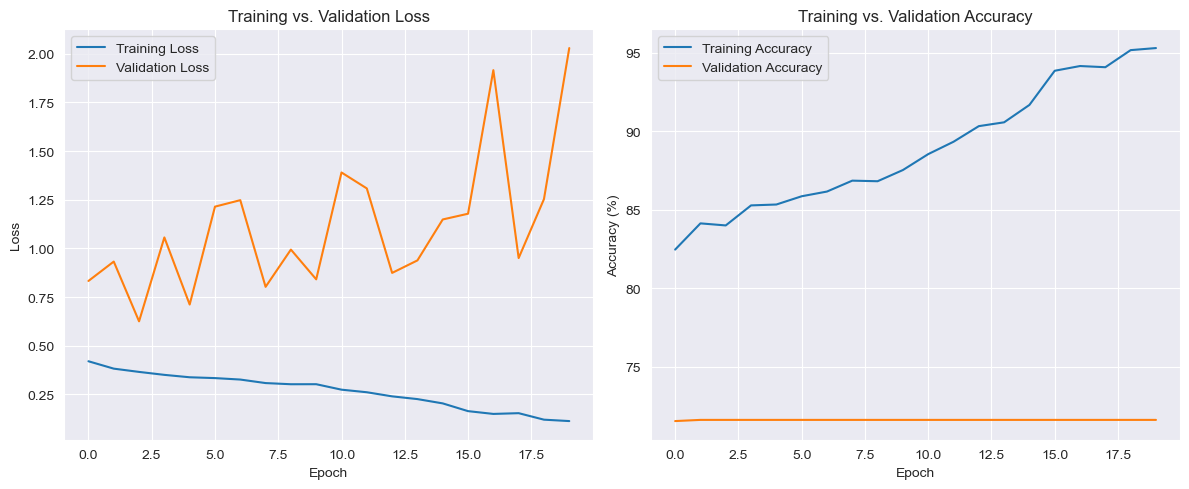

Epoch [1/20], Training Loss: 0.4529, Training Accuracy: 80.87%, Validation Loss: 1.3324, Validation Accuracy: 71.62%
Epoch [2/20], Training Loss: 0.3925, Training Accuracy: 83.09%, Validation Loss: 1.0623, Validation Accuracy: 71.62%
Epoch [3/20], Training Loss: 0.3848, Training Accuracy: 83.80%, Validation Loss: 0.6609, Validation Accuracy: 71.62%
Epoch [4/20], Training Loss: 0.3692, Training Accuracy: 84.23%, Validation Loss: 0.9362, Validation Accuracy: 71.62%
Epoch [5/20], Training Loss: 0.3567, Training Accuracy: 84.76%, Validation Loss: 0.9380, Validation Accuracy: 71.62%
Epoch [6/20], Training Loss: 0.3481, Training Accuracy: 85.59%, Validation Loss: 1.2339, Validation Accuracy: 71.62%
Epoch [7/20], Training Loss: 0.3456, Training Accuracy: 85.51%, Validation Loss: 1.2024, Validation Accuracy: 71.62%
Epoch [8/20], Training Loss: 0.3431, Training Accuracy: 85.36%, Validation Loss: 1.5489, Validation Accuracy: 71.62%
Epoch [9/20], Training Loss: 0.3305, Training Accuracy: 86.02%, 

KeyboardInterrupt: 

In [16]:

# Define number of folds
k_folds = 5  # Adjust this value based on your needs

# Create stratified k-fold object
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


# Lists to store metrics for each fold
fold_train_losses = []
fold_train_accuracies = []
fold_validation_losses = []
fold_validation_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(X=limited_train_df, y=limited_train_df["target"])):
    # Create training and testing DataFrames based on the indices
    train_df = limited_train_df.iloc[train_index]
    val_df = limited_train_df.iloc[val_index]
    
    # Update transform with fold-specific mean and standard deviation
    fold_transform = transforms.Compose([
      transforms.Resize((50, 50)),  # Resize to 50x50
      transforms.ToTensor(),  # Convert to tensor
      transforms.Normalize(mean=mean, std=std)  # Fold-specific normalization
    ])

    
    train_dataset = BreastCancerDataset(train_df, transform=fold_transform)  # Updated fold transform
    val_dataset = BreastCancerDataset(val_df, transform=base_transform) # Using base transform
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
    
    model = CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # L2 regularization
    criterion = nn.CrossEntropyLoss() # Check this part nn.BCEWithLogitsLoss()
    
    train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device)
    
    # Store fold-specific metrics
    fold_train_losses.append(train_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_validation_losses.append(validation_losses)
    fold_validation_accuracies.append(validation_accuracies)
    
    # Plot training and validation metrics for the current fold
    plot_metrics(train_losses, train_accuracies, validation_losses, validation_accuracies)
    
# After all folds are processed, you can optionally aggregate and summarize the results
# For example, calculate mean and standard deviation of metrics across folds
mean_train_loss = np.mean(fold_train_losses, axis=0)
mean_train_accuracy = np.mean(fold_train_accuracies, axis=0)
mean_validation_loss = np.mean(fold_validation_losses, axis=0)
mean_validation_accuracy = np.mean(fold_validation_accuracies, axis=0)

# Plot averaged training and validation metrics across all folds
plot_metrics(mean_train_loss, mean_train_accuracy, mean_validation_loss, mean_validation_accuracy)


# Hyperparameters search

In [ ]:
def train_validate_model(params, device):
    print(params)
    print()
    
    # Unpack parameters
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Prepare data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Model, criterion, and optimizer setup
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Use the previously implemented function for training and validation
    train_losses, train_accuracies, validation_losses, validation_accuracies = train_and_validate(
        model, train_loader, test_loader, criterion, optimizer, epochs, device
    )

    # Optional: Return more detailed training/validation outcomes
    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies,
        "best_validation_accuracy": max(validation_accuracies)  # Assumes validation_accuracies is not empty
    }

In [ ]:
# Example hyperparameter grid
param_space = {
    'epochs': [20, 30, 50],
    'batch_size': [128, 64, 32],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],
}

## Random search

In [ ]:
def sample_hyperparameters(space):
    sampled_params = {}
    for k, v in space.items():
        sampled_params[k] = random.choice(v)
    return sampled_params

# Number of different models search for random search
num_searches = 10 

best_accuracy = 0
best_params = None
best_model_metrics = None

for n_search in range(num_searches):
    print(f"Search {n_search} out of {num_searches}")
    params = sample_hyperparameters(param_space)

    model_metrics = train_validate_model(params, device)
    validation_accuracy = model_metrics['validation_accuracies'][-1]
    print(f"Validation accuracy: {validation_accuracy}\n")
    
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_params = params
        best_model_metrics = model_metrics

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")